# 6. Prediction network

Now that we have the pretrained encoder, we can use it as a feature extractor to feed informative features into a prediction network.

The prediction network (§3.2.2 in the paper) is a straight-forward feedforward network which takes in the extracted features and some additional 'external' features to predict a couple of time steps ahead.

The 'external' features consist of information about the prediction time that we know in advance. For example, the time of day, day of the week, whether or not it is a public holiday etc. By including a mechanism to incorporate such external features, prediction accuracy can be improved.


In [1]:
# allows for import from `src` directory
import sys 
sys.path.append('../')

from src import data
from src import utils

## 6.1 Set up data

In [2]:
params = utils.read_json_params('../parameters.json')

# run the data preprocessing pipeline to create dataset
df, _, samples = data.pipeline(params['data']['n_input_steps'], params['models']['prediction']['n_output_steps'], '../data')

# we modify the get_datasets function to return external features in the y labels
datasets = data.get_datasets(samples, params['data']['n_input_steps'], pretraining=False)


Data already downloaded

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00

17341 samples of 48 input steps and 4 output steps in train
3622 samples of 48 input steps and 4 output steps in valid
4060 samples of 48 input steps and 4 output steps in test



## 6.2 Prototype the prediction network

As mentioned above, the prediction network is a simple feedforward network that takes in two types of features and returns the prediction for the next handful of timesteps.

In [3]:
import torch.nn as nn

class Predict(nn.Module):
    def __init__(self, params, p, encoder_decoder: nn.Module):
        super(Predict, self).__init__()
        
        self.encoder = encoder_decoder.model['encoder'].eval()
        self.params = params
        self.model = nn.Sequential(
            nn.Linear(params['n_extracted_features'] + params['n_external_features'], params['predict_hidden_1']),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(params['predict_hidden_1'], params['predict_hidden_2']),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(params['predict_hidden_2'], params['n_output_steps'])
        )

    def forward(self, x):
        x_input, external = x
        extracted = self.encoder(x_input).view(-1, self.params['n_extracted_features'])
        x_concat = torch.cat([extracted, external], dim=-1)
        out = self.model(x_concat)
        return out

## 6.3 Train prediction network

In [4]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import os

def train_prediction_network(device, datasets, param_dict, params, use_tqdm=True):
    dataloaders = data.get_dataloaders(datasets, params['batch_size'])
    
    encoder_decoder_loc = os.path.join(param_dict['paths']['project_home'], 
                                       param_dict['paths']['artifacts'], 
                                       param_dict['artifacts']['encoder_decoder'])
    encoder_decoder = torch.load(encoder_decoder_loc)
    model = Predict(param_dict['models']['prediction'], params['dropout_p'], encoder_decoder)
    model.to(device)
    
    optimiser = optim.Adam(lr=params['learning_rate'],
                           params=model.model.parameters())
    loss_fn = F.mse_loss
    losses = {}
    losses['train'] = []
    losses['valid'] = []
    valid_loss = np.nan

    epochs = range(params['num_epochs'])
    if use_tqdm:
        from tqdm import tqdm
        epochs = tqdm(epochs)

    for epoch in epochs:
        for i,(x,y) in enumerate(dataloaders['train']):
            model.train()
            x,y = x.to(device),y.to(device)
            out = model((x,y[:,0,1:]))

            optimiser.zero_grad()
            loss = loss_fn(out, y[:,:,0])
            loss.backward()
            optimiser.step()

            step = i * params['batch_size'] + len(x)
            losses['train'].append([epoch * len(dataloaders['train'].dataset) + step, loss.item()])
            if use_tqdm:
                epochs.set_description(
                    'Epoch={0} | [{1:>5}|{2}]\ttrain. loss={3:.4f}\tvalid. loss={4:.4f}'
                    .format(epoch, step, len(dataloaders['train'].dataset),losses['train'][-1][1],valid_loss))

        valid_loss = evaluate_prediction_network(device, model, dataloaders['valid'])
        losses['valid'].append([epoch * len(dataloaders['train'].dataset) + step, valid_loss])

    return model, losses


def evaluate_prediction_network(device: str, model: nn.Module, valid_loader: DataLoader):
    loss_fn = F.mse_loss
    model = model.eval().to(device)
    for i,(x,y) in enumerate(valid_loader):
        break
    x, y = x.to(device), y.to(device)
    out = model((x,y[:,0,1:]))
    loss = loss_fn(out, y[:,:,0])

    return np.float32(loss.cpu().detach().numpy())


def hyperparameter_search(n_jobs: int, params:dict, name: str='prediction'):
    _, _, samples = data.pipeline(params['data']['n_input_steps'], 
                                  params['models']['prediction']['n_output_steps'], 
                                  params['paths']['data'])
    datasets = data.get_datasets(samples, params['data']['n_input_steps'],pretraining=False)
    device = utils.get_device()

    # set up ax
    from ax.service.ax_client import AxClient
    ax_client = AxClient(enforce_sequential_optimization=False)

    # define hyperparameter bounds 
    ax_client.create_experiment(
        name=name,
        parameters=[
            {"name": "num_epochs", "type": "range", "bounds": [80, 150]},
            {"name": "learning_rate", "type": "range", "bounds": [5e-4, 1e-3], "log_scale": True},
            {"name": "batch_size", "type": "range", "bounds": [64, 1024]},
            {"name": "dropout_p", "type": "range", "bounds": [0.2,0.5]}
        ],
        objective_name='loss',
        minimize=True
    )
    
    best = None
    min_valid_loss = np.inf
    for job in range(n_jobs):
        parameters, trial_index = ax_client.get_next_trial()
        model, losses = train_prediction_network(device, datasets, params, parameters)
        ax_client.complete_trial(trial_index=trial_index,
                                 raw_data=losses['valid'][-1][1])
        
        if losses['valid'][-1][1] < min_valid_loss:
            min_valid_loss = losses['valid'][-1][1]
            best = {
                'model': model,
                'losses': losses,
                'trial_index': trial_index,
                'parameters': parameters
            }
    
    print(f'Best parameters found after {n_jobs}:')
    print(ax_client.get_best_parameters())
    ax_client.save_to_json_file(os.path.join(params['paths']['project_home'],
                                             params['paths']['artifacts'],
                                             name +'.json'))

    return best

result = hyperparameter_search(10, params)

Data already downloaded

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00

17341 samples of 48 input steps and 4 output steps in train
3622 samples of 48 input steps and 4 output steps in valid
4060 samples of 48 input steps and 4 output steps in test



[INFO 09-14 22:58:23] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 09-14 22:58:23] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 09-14 22:58:23] ax.service.ax_client: Generated new trial 0 with parameters {'num_epochs': 82, 'learning_rate': 0.0, 'batch_size': 875, 'dropout_p': 0.22}.
Epoch=81 | [17341|17341]	train. loss=0.1046	valid. loss=0.1019: 100%|██████████| 82/82 [01:54<00:00,  1.40s/it]
[INFO 09-14 23:00:20] ax.service.ax_client: Completed trial 0 with data: {'loss': (0.1, None)}.
[INFO 09-14 23:00:20] ax.service.ax_client: Generated new trial 1 with parameters {'num_epochs': 132, 'learning_rate': 0.0, 'batch_size': 8

Best parameters found after 10:
({'num_epochs': 144, 'learning_rate': 0.0006031491105371974, 'batch_size': 201, 'dropout_p': 0.2}, ({'loss': 0.09491752254924547}, {'loss': {'loss': 3.89177573089728e-07}}))


### Plot loss

Text(0.5, 1.0, 'MSE Loss')

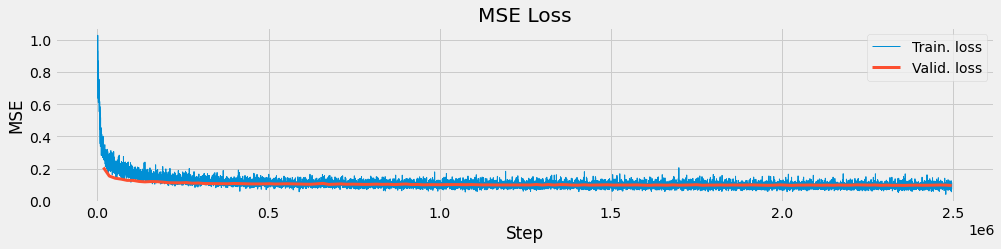

In [8]:
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

fig,axs = plt.subplots(1,1,figsize=(15,3))
axs.plot(*np.vstack(result['losses']['train']).T, lw=1, label='Train. loss')
axs.plot(*np.vstack(result['losses']['valid']).T, lw=3, label='Valid. loss')
axs.legend(loc='best')
axs.set_xlabel('Step')
axs.set_ylabel('MSE')
axs.set_title('MSE Loss')

### Save model

In [13]:
utils.save(result['model'], 'prediction')

PyTorch model saved at ../model_artifacts/prediction.pt


## 6.4 Make predictions with the pretrained encoder-decoder

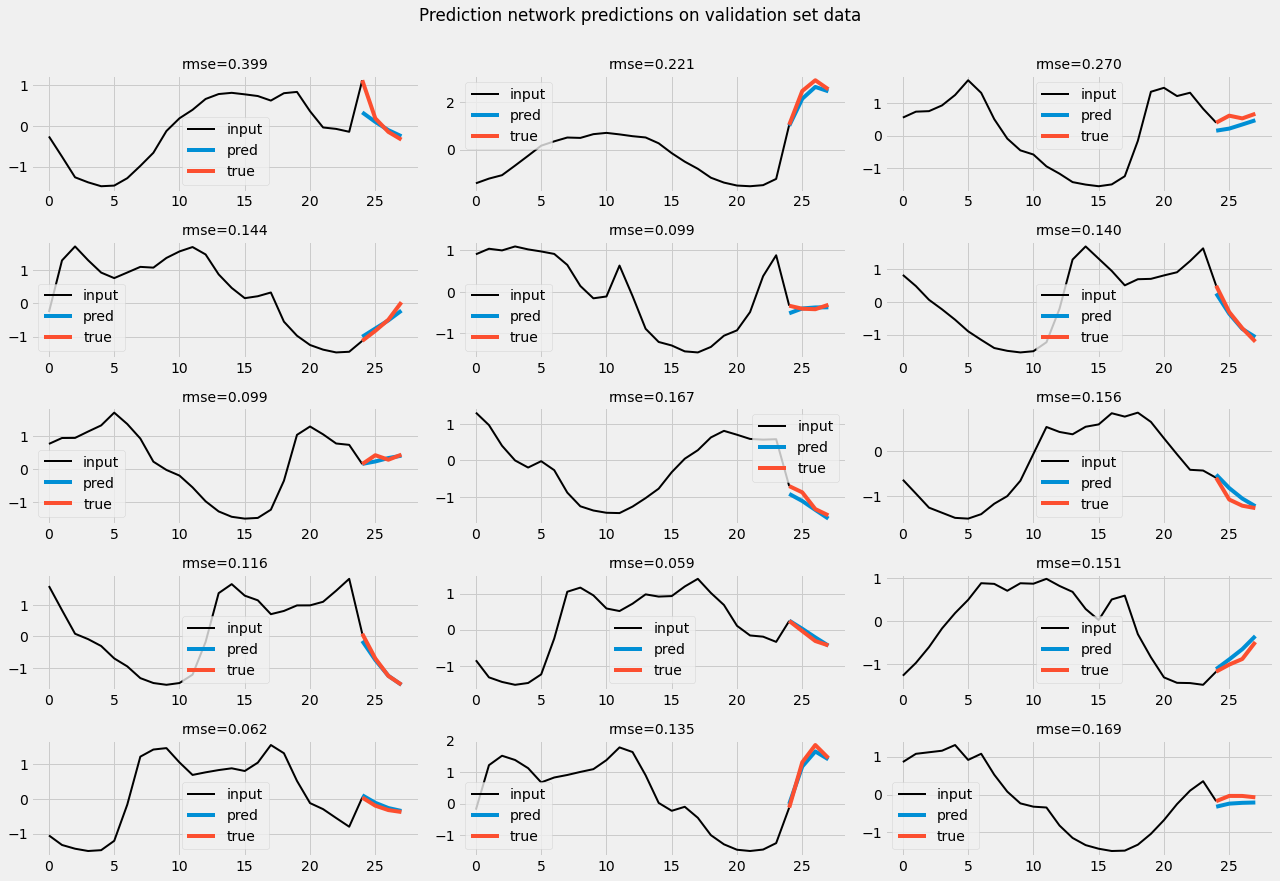

In [31]:
dataloaders = data.get_dataloaders(datasets, result['parameters']['batch_size'])
device = utils.get_device()
model = result['model'].to(device)

for x,y in dataloaders['valid']:
    break

y_pred = model((x.to(device), y[:,0,1:].to(device))).cpu().detach().numpy()[::30]
y = y[::30][:,:,0]
x = x[::30][:,:,4]
n_rows, n_cols = 5,3
fig,axs = plt.subplots(n_rows, n_cols,figsize=(6*n_cols, 2.5*n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_rows+c
        axs[r][c].plot(np.arange(25), np.hstack([x[i][-24:], y[i,0]]),label='input', c='k', lw=2)
        axs[r][c].plot(np.arange(24,28), y_pred[i], label='pred')
        axs[r][c].plot(np.arange(24,28), y[i,:], label='true')
        axs[r][c].legend()
        rmse = np.sqrt(np.mean((y_pred[i] - y[i,:].numpy())**2))
        axs[r][c].set_title('rmse={0:.3f}'.format(rmse),fontsize=14)
fig.suptitle('Prediction network predictions on validation set data\n')
plt.tight_layout()